In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
X, y = mnist['data'], mnist['target']; print(X.shape, y.shape)

(70000, 784) (70000,)


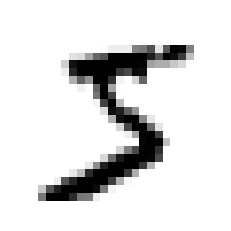

'5'

In [9]:
import matplotlib.pyplot as plt

some_digit =X[0].reshape(28,28)
plt.imshow(some_digit, cmap='binary')
plt.axis('off')
plt.show()

y[0]

In [28]:
import numpy as np
y = y.astype(np.uint8)
y[0]

5

In [51]:
def plt_images(instances, images_per_row, **options):
    size=28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    row_images=[]
    n_rows = (len(instances)-1)//images_per_row + 1
    print(n_rows)
    n_empty = n_rows*images_per_row - len(instances)
    images.append(np.zeros((size,size*n_empty)))
    for row in range(n_rows):
        r_images=images[row*images_per_row : (row+1)*images_per_row]
        row_images.append(np.concatenate(r_images,axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

10


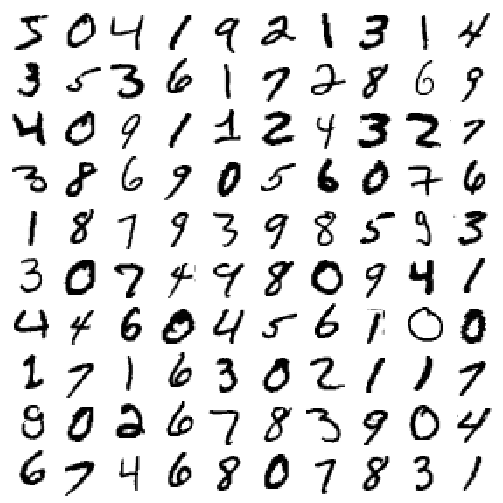

In [52]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plt_images(example_images, images_per_row=10)
plt.show()

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [18]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)
y_train[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [20]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [23]:
sgd_clf.predict(some_digit.reshape(1,784))

array([ True])

In [56]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import clone

split=StratifiedShuffleSplit(n_splits=3, random_state=42)

for train_index, test_index in split.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    
    train_set = X_train[train_index]
    train_y = y_train_5[train_index]
    test_set = X_train[test_index]
    test_y = y_train_5[test_index]
    
    clone_clf.fit(train_set, train_y)
    predicted_y= clone_clf.predict(test_set)
    accuracy=sum(predicted_y==test_y)/len(test_y)
    print('Accuracy:', round(accuracy,3))

Accuracy: 0.922
Accuracy: 0.966
Accuracy: 0.971


StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=None,
            train_size=None)

In [57]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [58]:
from sklearn.base import BaseEstimator

class NullClf(BaseEstimator):
    def fit(self, X, y):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype='bool')

In [59]:
never_5_clf = NullClf()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [62]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_pred[0:5]

array([ True, False, False, False, False])

In [63]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred, y_train_5)

array([[53892,  1891],
       [  687,  3530]], dtype=int64)

In [67]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_pred)

0.8370879772350012

In [68]:
recall_score(y_train_5, y_pred)

0.6511713705958311

In [71]:
y_score = sgd_clf.decision_function(some_digit.reshape(1,784))
y_score

array([2164.22030239])

In [72]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [75]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

0.4799852425751706
3370.0194991439557


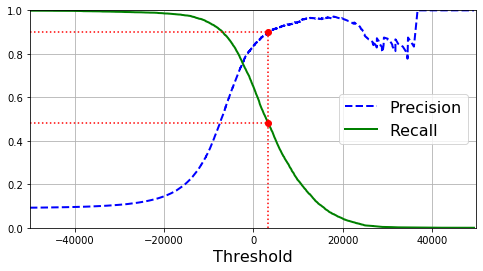

In [87]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                            
    plt.axis([-50000, 50000, 0, 1])             

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(recall_90_precision)
print(threshold_90_precision)

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")              
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                            
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                     
plt.show()

In [91]:
(y_pred == (y_scores > 0)).all()

True

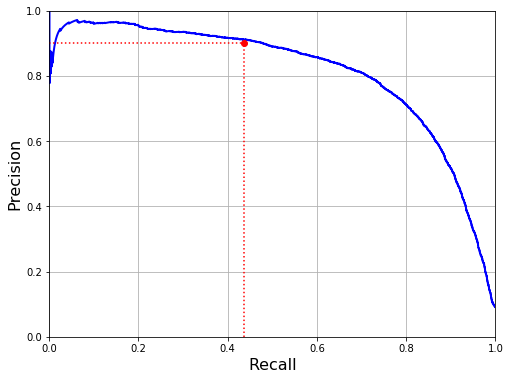

In [93]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

In [94]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [95]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [96]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706